# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

## Imports

In [5]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2 MB 7.5 kB/s eta 0:00:011    |█████████████████████           | 339.4 MB 6.2 MB/s eta 0:00:29
     |████████████████████████████████| 3.0 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 1.6 MB/s eta 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We reco

In [7]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 1925, done.
remote: Counting objects: 100% (1925/1925), done.
remote: Compressing objects: 100% (1682/1682), done.
remote: Total 1925 (delta 444), reused 763 (delta 225), pack-reused 0
Receiving objects: 100% (1925/1925), 30.08 MiB | 8.22 MiB/s, done.
Resolving deltas: 100% (444/444), done.


In [8]:
!ls 

 01_image_preprocessing.ipynb
 02_CNN_rgb_gray.ipynb
 03_CNN_rgb.ipynb
 04_CNN_gray.ipynb
'05_Object detection1.ipynb'
'06_Object detection2.ipynb'
 07_interactive_eager_few_shot_od_training_colab.ipynb
 images
 model
 models
 Prep_DatasetMaker
 README.md


#### [reference] tutorial of protoc
https://m.blog.naver.com/PostView.nhn?blogId=dschae9&logNo=221159192026&proxyReferer=https:%2F%2Fwww.google.com%2F
#### install protoc
google.github.io/proto-lens/installing-protoc.html


In [20]:
# Install the Object Detection API
# %%bash
# %cd models/research/
!ls
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

a3c_blogpost	    cvt_text	   lstm_object_detection  rebar
adversarial_text    deeplab	   marco		  setup.py
attention_ocr	    deep_speech    nst_blogpost		  slim
audioset	    delf	   object_detection	  vid2depth
autoaugment	    efficient-hrl  pcl_rl
cognitive_planning  lfads	   README.md
Processing /home/dayoung/dev/Models/models/research


  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1551679 sha256=cbc63989c871cba8cd06ad9ddff0961016400c04a7e7953c715084e7eefdf34b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nwdqehbm/wheels/84/73/20/e113578260c47525529b37376868329fa8fe61a07905b0ddde
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [56]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
import colabutils
from object_detection.builders import model_builder

%matplotlib inline

/home/dayoung/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


# Utilities

In [57]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  image= image.resize((im_width//10, im_height//10))
  return np.array(image.getdata()).reshape(
      (im_height//10, im_width//10, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
#   image_np_with_annotations = image_np.copy()
  image_np_with_annotations = image_np
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Rubber Ducky data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [58]:
# % pwd()
!pwd

/home/dayoung/dev/Models/models/research


In [39]:
%%bash
cd ../../
ls

01_image_preprocessing.ipynb
02_CNN_rgb_gray.ipynb
03_CNN_rgb.ipynb
04_CNN_gray.ipynb
05_Object detection1.ipynb
06_Object detection2.ipynb
07_interactive_eager_few_shot_od_training_colab.ipynb
images
model
models
object_detection
Prep_DatasetMaker
README.md


In [59]:
# from google.colab import drive
import os
import glob

# drive.mount('/content/drive')

# path = "/content/drive/My Drive/supergate/data/images/*"
# # file_list = os.listdir(path)
# file_list = glob.glob(path)
# file_list_img = sorted([file for file in file_list if file.endswith(".JPG")])
# file_list_img.pop(2)
# print ("file_list_img: {}".format(file_list_img))


path = "/home/dayoung/dev/Models/images/detect_target/"
file_list = os.listdir(path)
# file_list = glob.glob(path)
file_list_img = sorted([file for file in file_list if file.endswith(".JPG")])
print ("file_list_img: {}".format(file_list_img))


file_list_img: ['target (1).JPG', 'target (10).JPG', 'target (11).JPG', 'target (12).JPG', 'target (13).JPG', 'target (14).JPG', 'target (15).JPG', 'target (16).JPG', 'target (17).JPG', 'target (18).JPG', 'target (19).JPG', 'target (2).JPG', 'target (20).JPG', 'target (21).JPG', 'target (22).JPG', 'target (23).JPG', 'target (24).JPG', 'target (25).JPG', 'target (26).JPG', 'target (27).JPG', 'target (28).JPG', 'target (29).JPG', 'target (3).JPG', 'target (30).JPG', 'target (31).JPG', 'target (32).JPG', 'target (33).JPG', 'target (34).JPG', 'target (4).JPG', 'target (5).JPG', 'target (6).JPG', 'target (7).JPG', 'target (8).JPG', 'target (9).JPG']


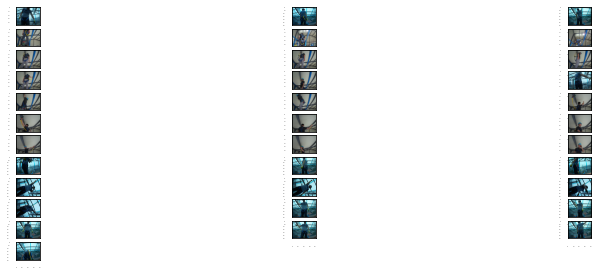

In [60]:
# Load images and visualize
train_images_np = []
for image_path in file_list_img :
  train_images_np.append(load_image_into_numpy_array(path+image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(len(file_list_img)//2+1, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



In [61]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [ ]:
# gt_boxes = [
#             np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
#             np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
#             np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
#             np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
#             np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
# ]

In [ ]:
gt_boxes

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [ ]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1
category_index = {duck_class_id: {'id': duck_class_id, 'name': 'hook'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


In [ ]:
print(len(gt_boxes), gt_boxes[1].shape)
print(len(train_images_np))
gt_boxes[0][0]

6 (2, 4)
6


array([0.00272222, 0.58064516, 0.07272222, 0.6674938 ])

In [ ]:
category_index


{1: {'id': 1, 'name': 'hook'}}

# Let's just visualize the rubber duckies as a sanity check


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):

boxes [[0.00272222 0.58064516 0.07272222 0.6674938 ]]
boxes [[0.00438889 0.58064516 0.07272222 0.66004963]]
boxes [[0.46605555 0.42431762 0.66938889 0.56079404]]
boxes [[0.00938889 0.58312655 0.09105555 0.6426799 ]]
boxes [[0.50772222 0.42183623 0.65772222 0.51116625]]
boxes [[0.00772222 0.58808933 0.08438889 0.65260546]]
boxes [[0.46605555 0.45657568 0.64272222 0.57568238]]
boxes [[0.00438889 0.57320099 0.08105555 0.65756824]]
boxes [[0.01272222 0.57568238 0.08272222 0.66997519]]
boxes [[0.46772222 0.42183623 0.66272222 0.5707196 ]]


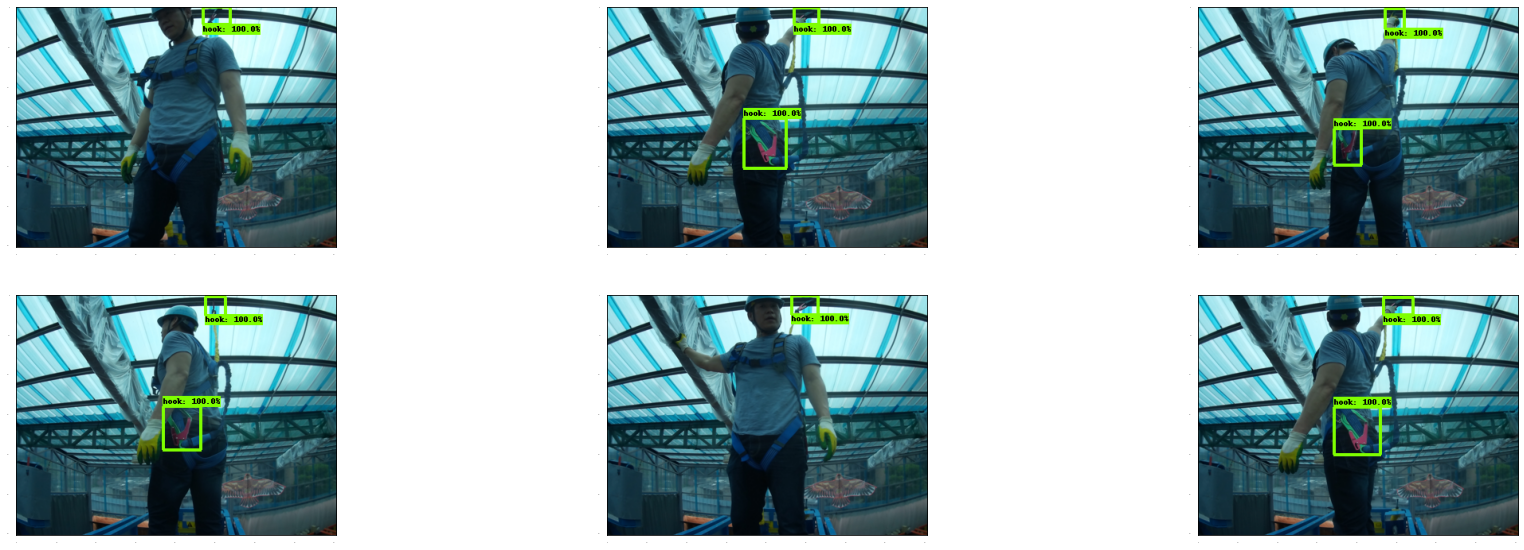

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
len_img=len(train_images_np)
for idx in range(len_img):
  plt.subplot(len_img//3+1, 3, idx+1)
  for i in range(gt_boxes[idx].shape[0]):
    plot_detections(
        train_images_np[idx],
        np.array([gt_boxes[idx][i]]),
        np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
        dummy_scores,
        category_index)
  
plt.show()

In [ ]:
}# from PIL import ImageColor

# def display_image(image):
#   fig = plt.figure(figsize=(20, 15))
#   plt.grid(False)
#   plt.imshow(image)

# def draw_bounding_box_on_image(image,
#                                ymin,
#                                xmin,
#                                ymax,
#                                xmax,
#                                color,
#                                font,
#                                thickness=4,
#                                display_str_list=()):
#   """Adds a bounding box to an image."""
#   draw = ImageDraw.Draw(image)
# #   im_width, im_height = image.size
# #   (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
# #                                 ymin * im_height, ymax * im_height)
# #   draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
# #              (left, top)],
# #             width=thickness,
# #             fill=color)

# #   # If the total height of the display strings added to the top of the bounding
# #   # box exceeds the top of the image, stack the strings below the bounding box
# #   # instead of above.
# #   print("display_str_list:",display_str_list)
# #   display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
# #   print("display_str_heights",display_str_heights)
# #   # Each display_str has a top and bottom margin of 0.05x.
# #   total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

# #   if top > total_display_str_height:
# #     text_bottom = top
# #   else:
# #     text_bottom = top + total_display_str_height
# #   # Reverse list and print from bottom to top.
# #   for display_str in display_str_list[::-1]:
# #     text_width, text_height = font.getsize(display_str)
# #     margin = np.ceil(0.05 * text_height)
# #     draw.rectangle([(left, text_bottom - text_height - 2 * margin),
# #                     (left + text_width, text_bottom)],
# #                    fill=color)
# #     draw.text((left + margin, text_bottom - text_height - margin),
# #               display_str,
# #               fill="black",
# #               font=font)
# #     text_bottom -= text_height - 2 * margin

# def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
#   """Overlay labeled boxes on an image with formatted scores and label names."""
#   colors = list(ImageColor.colormap.values())

#   try:
#     font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
#                               25)
#   except IOError:
#     print("Font not found, using default font.")
#     font = ImageFont.load_default()

#   for i in range(min(boxes.shape[0], max_boxes)):
#     if scores[i] >= min_score:
#       print("boxes[i]",boxes[0][i])
#       ymin, xmin, ymax, xmax = tuple(boxes[0][i])
#     #   display_str = "{}: {}%".format(class_names[i].decode("ascii"),
#     #                                  int(100 * scores[i]))
#         # category_index
#       print(class_names[1]['name'])
#       display_str = class_names[1]['name']
#       color = colors[hash(display_str) % len(colors)]
#       image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
#       draw_bounding_box_on_image(
#           image_pil,
#           ymin,
#           xmin,
#           ymax,
#           xmax,
#           color,
#           font,
#           display_str_list=[display_str])
#       np.copyto(image, np.array(image_pil))
#   return image


# image_with_boxes = draw_boxes(
#       train_images_np[2], np.array([gt_boxes[2]]),
#       category_index, dummy_scores)

# display_image(image_with_boxes)

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-08-12 06:12:39--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.212.128, 2607:f8b0:4001:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.212.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  44.3MB/s    in 5.6s    

2020-08-12 06:12:44 (41.7 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.5860921
batch 10 of 100, loss=0.42161655
batch 20 of 100, loss=0.23397134
batch 30 of 100, loss=0.14398986
batch 40 of 100, loss=0.08411362
batch 50 of 100, loss=0.060728222
batch 60 of 100, loss=0.054979037
batch 70 of 100, loss=0.043262657
batch 80 of 100, loss=0.034540948
batch 90 of 100, loss=0.034605615
Done fine-tuning!


# Load test images and run inference with new model!

In [ ]:
test_images_np = []
path = "/content/drive/My Drive/supergate/data/images/*"

file_list = glob.glob(path)
file_list_img = sorted([file for file in file_list if file.endswith(".JPG")])

for image_path in file_list_img :
  test_images_np.append(load_image_into_numpy_array(image_path))
# for i in range(1, 50):
#   image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
#   test_images_np.append(np.expand_dims(
#       load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly

@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  print("input_tensor",input_tensor)
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  print("="*30)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")
  


# len_img=len(train_images_np)
# for idx in range(len_img):
#   plt.subplot(len_img//3+1, 3, idx+1)
#   for i in range(gt_boxes[idx].shape[0]):
#     plot_detections(
#         train_images_np[idx],
#         np.array([gt_boxes[idx][i]]),
#         np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
#         dummy_scores,
#         category_index)

input_tensor Tensor("input_tensor:0", shape=(302, 403, 3), dtype=float32)


StagingError: ignored

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))